### Data
Raster : Regular images
Vector : 

In [ ]:
!pip install numpy scikit-learn opencv-python-headless pillow
!pip install --upgrade earthpy
!pip install --upgrade geopandas
!pip install --upgrade rioxarray

In [1]:
import rasterio
from rasterio.windows import Window
import os

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
from sklearn.preprocessing import StandardScaler
from shutil import copyfile

In [ ]:
## Cropland Detection Model with pseudo-labels 

## Data Preparation

In [1]:
import rasterio
from rasterio.windows import Window
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# RGB Normalization bands
def preprocess(band):
    # Step 1: Divide by 10,000
    band = band / 10000.0
    
    # Step 2: Clip to the range [0, 0.3]
    band = np.clip(band, 0, 0.3)
    
    return band

# Generic Normalization
def normalize_band(band, clip=False):
    if clip:
        band = preprocess(band)
    return (band - band.min()) / (band.max() - band.min())

def load_data(image_arr):
    # Assuming `data` is your numpy array of shape (27, 600, 1000)
    # Extract the Blue, Green, and Red bands
    blue = image_arr[2]
    green = image_arr[3]
    red = image_arr[4]
    ndvi = image_arr[-1]  # Last band for NDVI

    red_normalized = normalize_band(red, 0) # .astype(np.uint8)
    green_normalized = normalize_band(green, 0) # .astype(np.uint8)
    blue_normalized = normalize_band(blue, 0) # .astype(np.uint8)
    ndvi_normalized = normalize_band(ndvi)

    # Stack the normalized bands to create an RGB image
    rgb_image = np.stack([red_normalized, green_normalized, blue_normalized], axis=-1)

    return rgb_image, ndvi_normalized

In [3]:
before_tif = 'sentinel/NDVI_Before_Tillage.tif'
after_tif = 'sentinel/NDVI_After_Tillage.tif'

 ## Take a snippet for image
ROW_START = 200
ROW_END = 800
COL_START = 200
COL_END = 1200

with rasterio.open(before_tif) as src:
    before_desc = src.descriptions
    before = src.read()

with rasterio.open(after_tif) as src:
    after_desc = src.descriptions
    after = src.read()


before = before[:, ROW_START:ROW_END, COL_START:COL_END ]
after = after[:, ROW_START:ROW_END, COL_START:COL_END ]

before_rgb, before_ndvi = load_data(before)
after_rgb, after_ndvi = load_data(after)

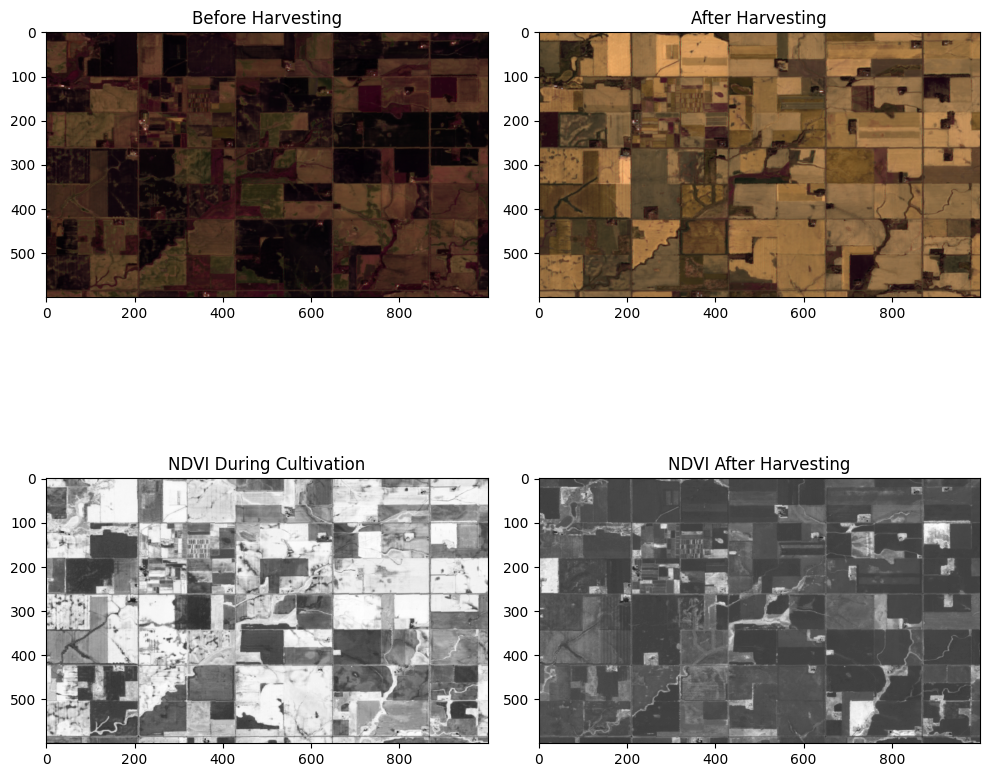

In [24]:
# plt.figure(figsize=(12, 6))  # Create a figure with a width and height
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot the "before" image
axes[0,0].imshow(before_rgb)
axes[0,0].set_title("Before Harvesting")
# axes[0,0].axis('off')  # Turn off the axis

# Save just the portion _inside_ the second axis's boundaries
extent = axes[0,0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig('ax2_figure.png', bbox_inches=extent)
# Pad the saved area by 10% in the x-direction and 20% in the y-direction
fig.savefig('ax2_figure_expanded.png', dpi=300, bbox_inches=extent.expanded(1.1, 1.2), pad_inches=0 )

# axes[0,0].savefig("high_quality_image1.png", dpi=300, bbox_inches='tight', pad_inches=0)

# Plot the "after" image
axes[0,1].imshow(after_rgb)
axes[0,1].set_title("After Harvesting")
# axes[0,1].axis('off')  # Turn off the axis

# Plot the "before" ndvi image
axes[1, 0].imshow(before_ndvi, cmap='gray')
axes[1, 0].set_title("NDVI During Cultivation")

# Plot the "after" ndvi image
axes[1, 1].imshow(after_ndvi, cmap='gray')
axes[1, 1].set_title("NDVI After Harvesting")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

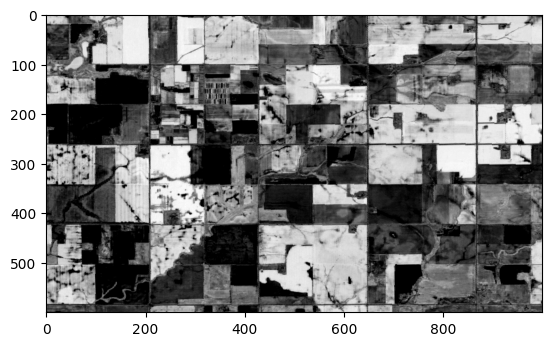

In [14]:
## Prepare Label. This shows cropland. 
# See how much change happened before and after ... 
change = before_ndvi - after_ndvi
# Only use change from before to After.
change[change<=0] = 0
change = ( change - change.min() ) / (change.max() - change.min())

plt.imshow(change, cmap='gray')
plt.savefig("high_quality_image1.png", dpi=300, bbox_inches='tight', pad_inches=0)

In [15]:
before.shape, after.shape, change.shape

((27, 600, 1000), (27, 600, 1000), (600, 1000))

In [16]:
# Define the tile size
TILE_SIZE = 256

In [17]:
# Assuming your original array is named `array` with shape (N, 1443, 1499)
_, H, W = before.shape

# Calculate the number of tiles that fit in each dimension
num_tiles_y = H // TILE_SIZE  # Number of tiles along the height
num_tiles_x = W // TILE_SIZE  # Number of tiles along the width

print(num_tiles_x, num_tiles_y)

# Initialize a list to store the tiles
tiles_before = []
tiles_after = []
tiles_changes = []

# Loop through the height and width to extract each tile
for i in range(num_tiles_y):
    for j in range(num_tiles_x):
        row_start, row_end = i*TILE_SIZE, (i+1)*TILE_SIZE
        col_start, col_end = j*TILE_SIZE, (j+1)*TILE_SIZE
 
        # Extract the tile
        tile_before = before[:, row_start:row_end, col_start:col_end ]
        tile_after = after[ :, row_start:row_end, col_start:col_end ]
        tile_change = change[ row_start:row_end, col_start:col_end ]
        tiles_before.append(tile_before)
        tiles_after.append(tile_after)
        tiles_changes.append(tile_change)

# Convert list of tiles to numpy array
tiles_before = np.array(tiles_before)
tiles_after = np.array(tiles_after)
tiles_changes = np.array(tiles_changes)

# print(tiles_before.shape)  # Expected shape: (num_tiles_y * num_tiles_x, N, 256, 256)

3 2


In [18]:
def per_channel_normalize(x):
    '''
    x : numpy array of shape (channel, height, width)
    '''
    out = (x.T - x.min((1,2))) / (x.max((1,2)) - x.min((1,2)))
    return out.transpose(2,1,0)

## Visualize final training images

/var/folders/5q/d5sngbr11bj5s27jzhrdww2r0000gn/T/ipykernel_28177/3939977211.py:5: RuntimeWarning: invalid value encountered in divide
  out = (x.T - x.min((1,2))) / (x.max((1,2)) - x.min((1,2)))


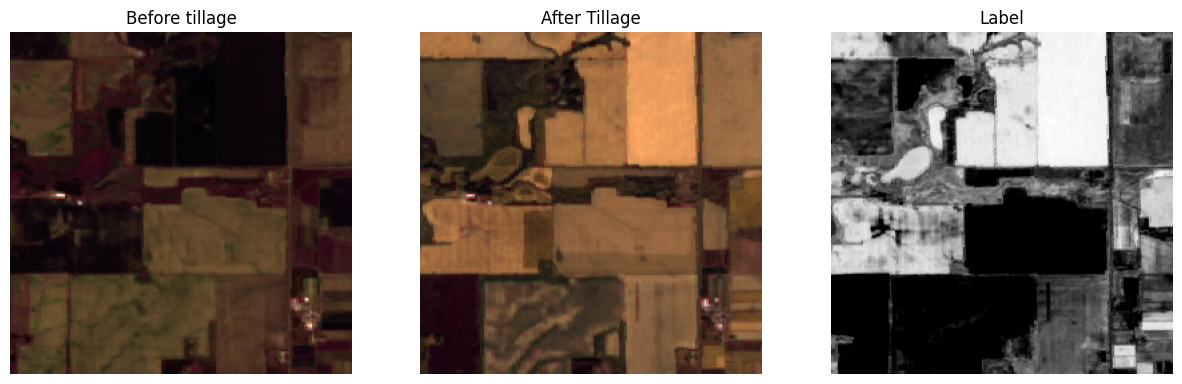

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(
    per_channel_normalize( tiles_before[0] ) # shape is : c,h,w
    .transpose(1,2,0) # change to : h,w,c
    [ :, : , [4,3,2] ] ) # select specific channels
ax[0].set_title("Before tillage")
ax[0].axis('off')

ax[1].imshow(
    per_channel_normalize( tiles_after[0] ) # shape is : c,h,w
    .transpose(1,2,0) # change to : h,w,c
    [ :, : , [4,3,2] ] ) # select specific channels
ax[1].set_title("After Tillage")
ax[1].axis('off')

ax[2].imshow(tiles_changes[0], cmap='gray')
ax[2].set_title("Label")
ax[2].axis('off')

plt.show()

## Train the Segmentation model

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

In [27]:
CHANNELS_INDEXES = [4,3,2] ## channels to use in modeling
BATCH_SIZE = 6
NUM_CHANNELS = len(CHANNELS_INDEXES)

In [28]:
class CropLandDataset(Dataset):
    def __init__(self, X_images_before, X_images_after, Y_masks, channels_idx=[], transform=None):
        self.X_images_before = X_images_before
        self.X_images_after = X_images_after
        self.Y_masks = Y_masks
        self.transform = transform

        self.X_combined = np.concatenate( (self.X_images_before, self.X_images_after) , axis=0)
        self.Y_combined = np.concatenate( (self.Y_masks, self.Y_masks) , axis=0)
        if not channels_idx:
            self.channels_idx = CHANNELS_INDEXES # Use RGB Bands by default
        else:
            self.channels_idx = channels_idx # Use supplied band otherwise

    def __len__(self):
        return len(self.X_combined)

    def __getitem__(self, idx):
        # print('index is :', idx)
        # print("Len X : ", len(self.X_combined))
        # print("Len Y : ", len(self.Y_combined))
        X = self.X_combined[idx]
        # X = X.transpose( (1,2,0) )
        X = X[ self.channels_idx, : , :  ]
        X = per_channel_normalize(X)
        
        Y = self.Y_combined[idx]

        # print(X.shape, Y.shape)
        if self.transform:
            print("Applying Transformation ... ")
            X = self.transform(X)
        return X, Y


# Define any transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor and scales pixel values between 0 and 1
])

# Create dataset and dataloader
dataset = CropLandDataset(
    X_images_before=tiles_before,
    X_images_after=tiles_after,
    Y_masks=tiles_changes,
    transform=None
    )

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [29]:
for test in dataloader:
    break

In [30]:
test[0][0].shape, test[1][0].shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

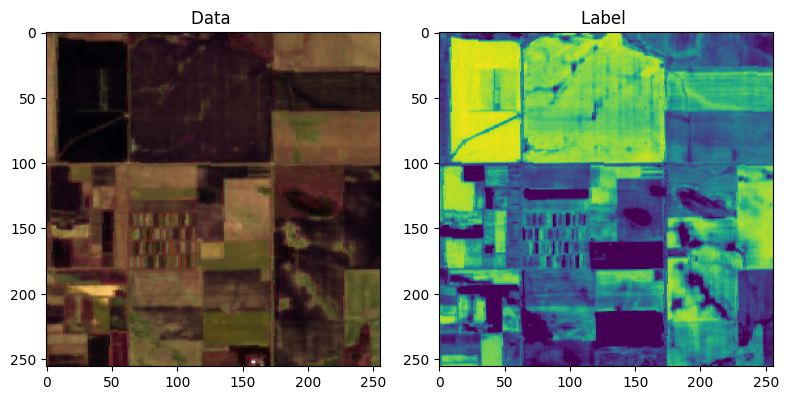

In [31]:
## Plot second item of batch
fig, axes = plt.subplots(1, 2, figsize=(8, 8))

# Plot the "input" 
axes[0].imshow(  test[0][1].permute((1,2,0) )  )
axes[0].set_title("Data ")
# axes[0].axis('off')  # Turn off the axis

# Plot the "label" 
axes[1].imshow(test[1][1])
axes[1].set_title("Label ")
# axes[1].axis('off')  # Turn off the axis

plt.tight_layout()
plt.show()

In [78]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=1),
            nn.Sigmoid()  # Final sigmoid activation

        )
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x1 = self.encoder(x)
        # print(x1.shape)
        x2 = self.middle(x1)
        # print(x2.shape)
        x3 = self.up(x2)
        # print(x3.shape)
        x4 = self.decoder(x3)
        # print(x4.shape)
        
        return x4

# Create an instance of the U-Net
in_channels = NUM_CHANNELS  # Number of channels in X
out_channels = 1  # Single-channel output for probability map
model = UNet(in_channels, out_channels)

In [79]:
model

UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (middle): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    (3): Sigmoid()
  )
  (up): Upsample(scale_factor=2.0, mode='bilinear')
)

In [80]:
from torchsummary import summary
# !pip install torchsummary

In [81]:
summary(model, (3,256,256) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
         Upsample-10        [-1, 128, 256, 256]               0
           Conv2d-11         [-1, 64, 256, 256]          73,792
             ReLU-12         [-1, 64, 256, 256]               0
           Conv2d-13          [-1, 1, 256, 256]              65
          Sigmoid-14          [-1, 1, 2

In [82]:
# Define the loss function and optimizer
# criterion = nn.BCEWithLogitsLoss()  # This combines sigmoid and binary cross-entropy in one step
criterion = nn.BCELoss()  # Use BCELoss instead of BCEWithLogitsLoss

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [83]:
## Run a test output of Model .. 
test_output = model(test[0].float()) # Input be B, C , H, W , Output of shape : B, 1, H , W

In [84]:
test[0].shape

torch.Size([6, 3, 256, 256])

In [85]:
test_output.squeeze().shape, test[1].shape

(torch.Size([6, 256, 256]), torch.Size([6, 256, 256]))

In [86]:
for X_batch, Y_batch in dataloader:
    print(len(X_batch))

6
6


In [87]:
num_epochs = 50  # Adjust based on your needs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, Y_batch in dataloader:
        X_batch, Y_batch = X_batch.float(), Y_batch.float()  # Ensure data types
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), Y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Todo : Add a validation dataloader like above ..

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")

Epoch [1/50], Loss: 0.6918
Epoch [2/50], Loss: 0.6885
Epoch [3/50], Loss: 0.6830
Epoch [4/50], Loss: 0.6815
Epoch [5/50], Loss: 0.6806
Epoch [6/50], Loss: 0.6791
Epoch [7/50], Loss: 0.6766
Epoch [8/50], Loss: 0.6734
Epoch [9/50], Loss: 0.6692
Epoch [10/50], Loss: 0.6640
Epoch [11/50], Loss: 0.6581
Epoch [12/50], Loss: 0.6519
Epoch [13/50], Loss: 0.6446
Epoch [14/50], Loss: 0.6364
Epoch [15/50], Loss: 0.6285
Epoch [16/50], Loss: 0.6249
Epoch [17/50], Loss: 0.6191
Epoch [18/50], Loss: 0.6183
Epoch [19/50], Loss: 0.6138
Epoch [20/50], Loss: 0.6162
Epoch [21/50], Loss: 0.6119
Epoch [22/50], Loss: 0.6099
Epoch [23/50], Loss: 0.6106
Epoch [24/50], Loss: 0.6079
Epoch [25/50], Loss: 0.6070
Epoch [26/50], Loss: 0.6064
Epoch [27/50], Loss: 0.6058
Epoch [28/50], Loss: 0.6063
Epoch [29/50], Loss: 0.6080
Epoch [30/50], Loss: 0.6231
Epoch [31/50], Loss: 0.5983
Epoch [32/50], Loss: 0.6106
Epoch [33/50], Loss: 0.6060
Epoch [34/50], Loss: 0.6027
Epoch [35/50], Loss: 0.6017
Epoch [36/50], Loss: 0.6064
E

In [88]:
len(test[1]), test[1][0]

(6,
 tensor([[0.8331, 0.8514, 0.8298,  ..., 0.3364, 0.3160, 0.2564],
         [0.8469, 0.8263, 0.8025,  ..., 0.4096, 0.3625, 0.2876],
         [0.8402, 0.8022, 0.8050,  ..., 0.4716, 0.4547, 0.3928],
         ...,
         [0.3780, 0.4621, 0.4951,  ..., 0.0000, 0.0000, 0.1176],
         [0.3944, 0.4343, 0.5096,  ..., 0.0000, 0.0000, 0.1034],
         [0.5015, 0.5313, 0.5528,  ..., 0.0000, 0.0000, 0.0402]],
        dtype=torch.float64))

## Look at output of Model

In [130]:
## Now look at how model is performing
with torch.no_grad():  
    ## Run a test output of Model .. 
    test_output = model(test[0].float())

In [131]:
actual_image = test[0][0].permute((1,2,0) ) # First example of test-batch
actual_croparea = test[1][0] # First example of test-batch
pred_croparea = test_output.squeeze()[0]

pred_croparea_hard = pred_croparea.clone().detach()


THRESH = 0.6
pred_croparea_hard[ pred_croparea_hard > THRESH ] = 1
pred_croparea_hard[ pred_croparea_hard < THRESH ] = 0

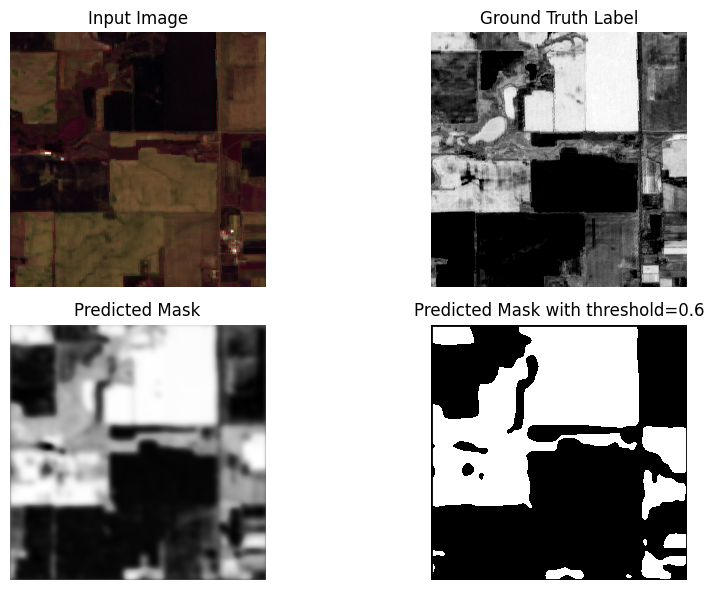

In [134]:
# Function to plot input image and prediction side by side
fig, ax = plt.subplots(2, 2, figsize=(10, 6) )
# ax.patch.set_edgecolor('black')  
# ax.patch.set_linewidth(1)  

# Plot the input image
ax[0,0].imshow( actual_image )  
ax[0,0].set_title("Input Image")
ax[0,0].axis('off')

# Plot the ground truth label
ax[0,1].imshow(actual_croparea, cmap='gray')
ax[0,1].set_title("Ground Truth Label")
ax[0,1].axis('off')

# Plot the prediction
ax[1,0].imshow(pred_croparea, cmap='gray')
ax[1,0].set_title("Predicted Mask")
ax[1,0].axis('off')

# Plot the prediction with threshold
import matplotlib.patches as patches

rect = patches.Rectangle(
    (-0.5, -0.5), 256, 256, linewidth=2, edgecolor='black', facecolor='none'
)
ax[1,1].add_patch(rect)

ax[1,1].imshow(pred_croparea_hard, cmap='gray')
ax[1,1].set_title(f"Predicted Mask with threshold={THRESH}")
ax[1,1].axis('off')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


(array([19904.,  5781.,  4942.,  3825.,  2567.,  4117.,  5685.,  4171.,
         3507., 11037.]),
 array([0.22429352, 0.29308975, 0.36188599, 0.43068221, 0.49947846,
        0.56827468, 0.63707095, 0.70586717, 0.77466339, 0.84345967,
        0.91225588]),
 <BarContainer object of 10 artists>)

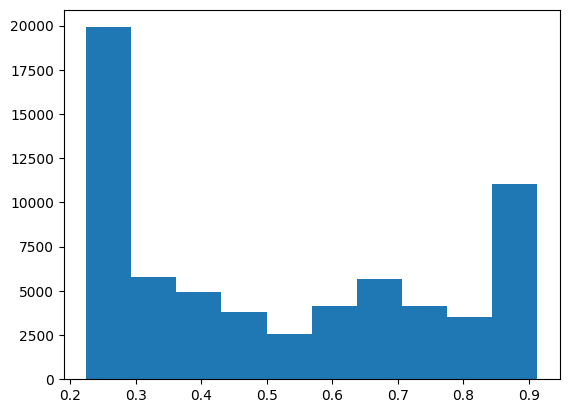

In [95]:
plt.hist(pred_croparea.flatten())

## Possible Next Steps :
- ( NOT SURE ) Create small Human-annotated accuracy set with Domain Experts
    - FineTune model this dataset. 

- Experiment with  : 
    - Pretrained encoder like VGG 
    - Use constrastive learning to train custom-encoder and use that in the segmentation model.
    - Multi-task learning setting : Predict both Cropland and Vegetation at the Same time.
        - Pseudo Labels for Vegetation can also be created.